In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Lulesh Data

In [2]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/ault/lulesh_27/lulesh_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed time", fp):
            size = int(f.split('_')[-2])
            data.append([size, float(line.split()[-2])])
                
normal_lulesh_ault = pd.DataFrame(data=data, columns=['lulesh_size', 'time'])
normal_lulesh_ault['system'] = 'ault'
normal_lulesh_ault['type'] = 'baseline'
normal_lulesh_ault['benchmark'] = 'lulesh'
normal_lulesh_ault['application'] = 'lulesh'
#normal_lulesh_ault['benchmark-type'] = normal_lulesh_ault.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_lulesh_ault['ranks'] = 27
normal_lulesh_ault['nodes'] = 1
#baseline_data = pd.concat([normal_lulesh_ault, normal_milc_ault])
#print(baseline_data)
#print(lulesh_time.groupby(['lulesh_size']).mean())
#print(lulesh_time.groupby(['lulesh_size']).std() / lulesh_time.groupby(['lulesh_size']).mean())


# New LULESH data

In [3]:
data = []
for type in ['read', 'write']:

    for pause in [100000, 10000, 1000, 250000, 25000, 500000, 50000, 5000]:

        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_rma/lulesh/{type}_{pause}_10485760/lulesh_*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed time", fp):
                    size = int(f.split('_')[-2])
                    data.append([type, pause, size, float(line.split()[-2])])
                
rma_ault = pd.DataFrame(data=data, columns=['type', 'pause', 'lulesh_size', 'time'])
#rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)
rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()[0:1]}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)

rma_ault.sort_values('benchmark-type', inplace=True)

In [28]:

#rma_ault['new-index'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)
mean_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).mean().reset_index()
median_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).median().reset_index()
dev_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).std().reset_index()
mean_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).std().reset_index()

#print(mean_lulesh)
#print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
#df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
df1['slowdown_dev'] = df1['slowdown']*np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
print(df1)

df1.reset_index(inplace=True)
df1['slowdown'] = (df1['slowdown']-1)*100
df1['slowdown_dev'] = df1['slowdown_dev']*100
from natsort import natsort_keygen

print(df1)


df1.sort_values(['benchmark-type', 'lulesh_size'], inplace=True, key=natsort_keygen())
#df1['new-index'] = df1.apply(lambda row: row['benchmark-type']. f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)

            benchmark-type     pause        time  original_time  slowdown  \
lulesh_size                                                                 
10               (R, 1 ms)    1000.0    4.500014       4.306922  1.044833   
10              (R, 10 ms)   10000.0    4.493721       4.306922  1.043372   
10             (R, 100 ms)  100000.0    4.495624       4.306922  1.043814   
10              (R, 25 ms)   25000.0    4.496506       4.306922  1.044019   
10             (R, 250 ms)  250000.0    4.495110       4.306922  1.043694   
...                    ...       ...         ...            ...       ...   
25              (W, 25 ms)   25000.0  184.331016     176.968644  1.041603   
25             (W, 250 ms)  250000.0  184.224744     176.968644  1.041002   
25               (W, 5 ms)    5000.0  184.810344     176.968644  1.044311   
25              (W, 50 ms)   50000.0  184.257636     176.968644  1.041188   
25             (W, 500 ms)  500000.0  184.211211     176.968644  1.040926   

# Plot LULESH

In [31]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, hue=None, **kwargs):

    y_values = []
    yerr_values = []
    for hue_value in data[hue].unique():
        for x_value in data[x].unique():
            row = data.loc[(data[hue] == hue_value) & (data[x] == x_value)]
            y_values.append(row[y].values[0])
            yerr_values.append(row[yerr].values[0])
        
    _ax = sns.barplot(x=x,y=y,data=data, hue=hue, **kwargs)
    
    x_coords = [p.get_x() + 0.5*p.get_width() for p in _ax.patches]
    y_coords = [p.get_height() for p in ax.patches]

    _, caps,_ = _ax.errorbar(x=x_coords, y=y_coords, yerr=yerr_values, linewidth=2, 
                             solid_capstyle='round', solid_joinstyle='round', color='#464646', fmt="none", capsize=2)
    

    for cap in caps:
        cap.set_markeredgewidth(2)
        cap._marker._capstyle = matplotlib._enums.CapStyle.round

    return _ax


In [30]:
df1

,lulesh_size,benchmark-type,pause,time,original_time,slowdown,original_dev,dev,slowdown_dev
0,10,"(R, 1 ms)",1000.0,4.500014,4.306922,4.483301,0.188483,0.005592,4.574328
16,15,"(R, 1 ms)",1000.0,24.358931,22.756354,7.042330,0.508858,0.014943,2.394488
32,18,"(R, 1 ms)",1000.0,48.896986,46.070855,6.134316,0.795702,0.023736,1.833799
48,20,"(R, 1 ms)",1000.0,75.567803,70.792680,6.745221,1.191206,0.068979,1.798809
64,25,"(R, 1 ms)",1000.0,188.768404,176.968644,6.667712,2.418913,0.051151,1.458284
...,...,...,...,...,...,...,...,...,...
15,10,"(W, 500 ms)",500000.0,4.492074,4.306922,4.298958,0.188483,0.003722,4.565236
31,15,"(W, 500 ms)",500000.0,23.748060,22.756354,4.357933,0.508858,0.035648,2.338813
47,18,"(W, 500 ms)",500000.0,47.827237,46.070855,3.812351,0.795702,0.028575,1.794044
63,20,"(W, 500 ms)",500000.0,73.636534,70.792680,4.017158,1.191206,0.035804,1.750995


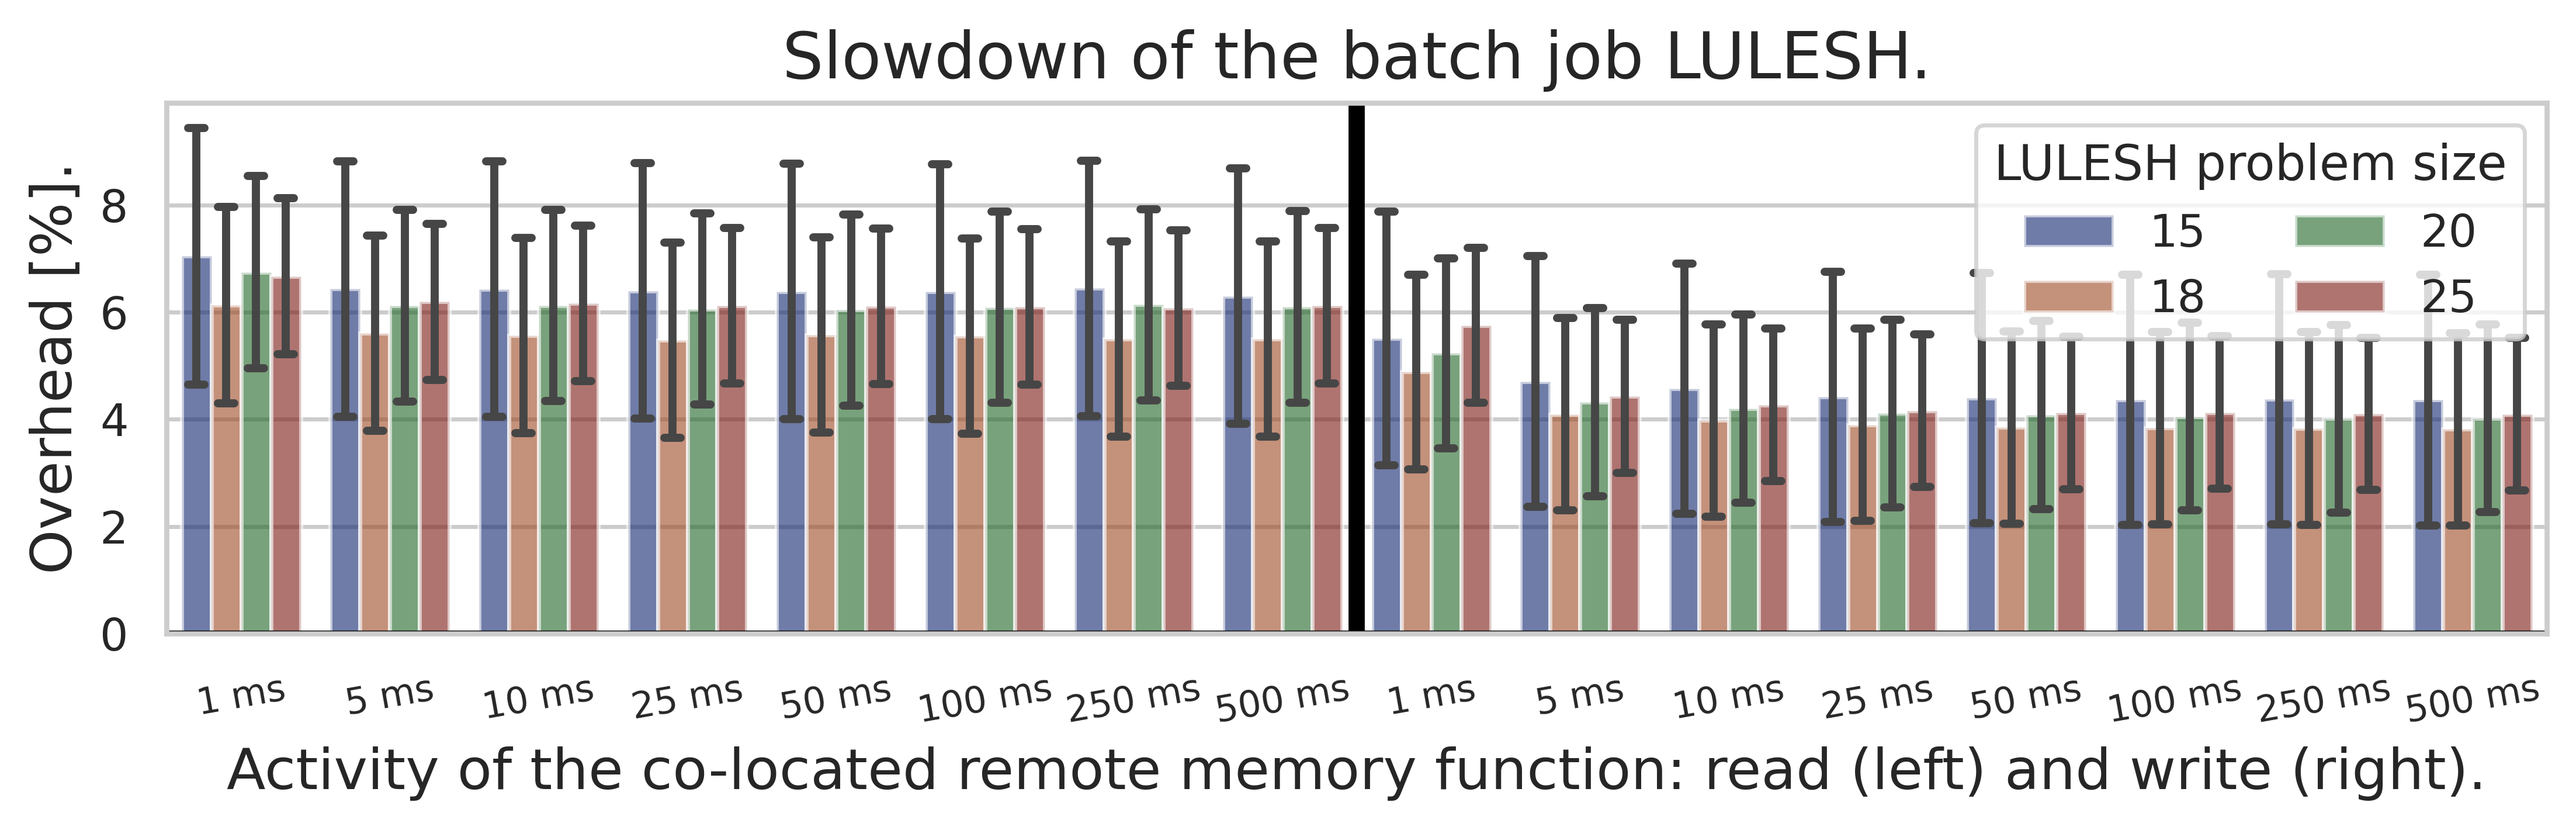

In [48]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_xlim([-0.5,15.5])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
plt.xticks(ticks,labels,fontsize=9, rotation=10)
#plt.xtickslabels(['a'])


plt.annotate("Baseline LULESH execution times:\n24.3, 48.4, 74.2, 191.8 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(1.5, -3.5), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.axvline(7.5, 0,5,color='black',linewidth=4)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "memory", "colocation_rma_lulesh.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)


# Plot LULESH Poster

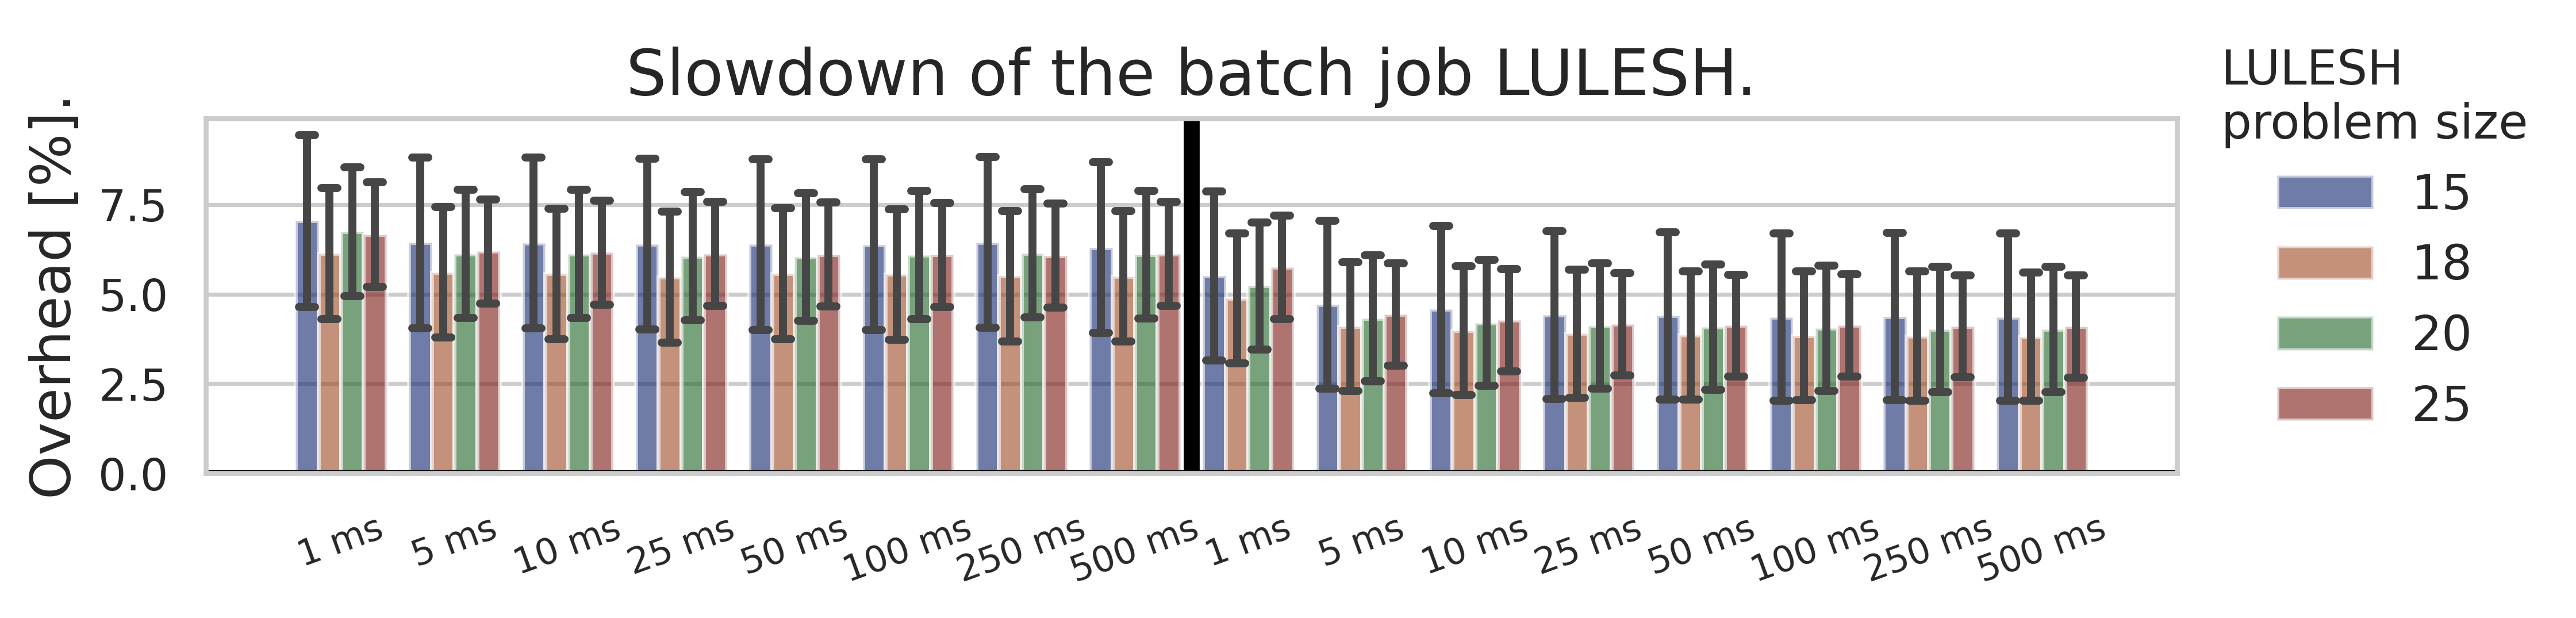

In [33]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9, 2.25))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('')
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(
    title='LULESH\nproblem size',
    fontsize=12,
    ncol=1,
    bbox_to_anchor=(1.2, 0),
    loc="lower right",
    frameon=False
)
g.axhline(y=0, color='black', linestyle='-')

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
plt.xticks(ticks,labels,fontsize=9, rotation=20)
#plt.xtickslabels(['a'])


plt.axvline(7.5, 0,5,color='black',linewidth=4)

plt.tight_layout()
plt.savefig(os.path.join('plots', "memory", "colocation_rma_lulesh_poster.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)


# LULESH 125

In [49]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/ault/lulesh_125/lulesh_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed time", fp):
            size = int(f.split('_')[-2])
            data.append([size, float(line.split()[-2])])
                
normal_lulesh_ault = pd.DataFrame(data=data, columns=['lulesh_size', 'time'])
normal_lulesh_ault['system'] = 'ault'
normal_lulesh_ault['type'] = 'baseline'
normal_lulesh_ault['benchmark'] = 'lulesh'
normal_lulesh_ault['application'] = 'lulesh'
#normal_lulesh_ault['benchmark-type'] = normal_lulesh_ault.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_lulesh_ault['ranks'] = 125
normal_lulesh_ault['nodes'] = 1
#baseline_data = pd.concat([normal_lulesh_ault, normal_milc_ault])
#print(baseline_data)
#print(lulesh_time.groupby(['lulesh_size']).mean())
#print(lulesh_time.groupby(['lulesh_size']).std() / lulesh_time.groupby(['lulesh_size']).mean())


In [50]:
data = []
for type in ['read', 'write']:

    for pause in [100000, 10000, 1000, 250000, 25000, 500000, 50000, 5000]:

        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_rma/lulesh_125/{type}_{pause}_10485760/lulesh_*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed time", fp):
                    size = int(f.split('_')[-2])
                    data.append([type, pause, size, float(line.split()[-2])])
                
rma_ault = pd.DataFrame(data=data, columns=['type', 'pause', 'lulesh_size', 'time'])
#rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)
rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()[0:1]}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)

rma_ault.sort_values('benchmark-type', inplace=True)

In [56]:

#rma_ault['new-index'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)
mean_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).mean().reset_index()
median_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).median().reset_index()
dev_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).std().reset_index()
mean_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh_ault.groupby(['lulesh_size']).std().reset_index()

#print(mean_lulesh)
#print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
#df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
df1['slowdown_dev'] = df1['slowdown']*np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

df1.reset_index(inplace=True)
df1['slowdown'] = (df1['slowdown']-1)*100
df1['slowdown_dev'] = df1['slowdown_dev']*100
from natsort import natsort_keygen



df1.sort_values(['benchmark-type', 'lulesh_size'], inplace=True, key=natsort_keygen())
df1
#df1['new-index'] = df1.apply(lambda row: row['benchmark-type']. f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)

,lulesh_size,benchmark-type,pause,time,original_time,slowdown,original_dev,dev,slowdown_dev
0,15,"(R, 1 ms)",1000.0,53.930816,51.230389,5.271143,0.060519,0.211128,0.430468
16,18,"(R, 1 ms)",1000.0,93.143004,89.176694,4.447697,0.092091,0.056450,0.125065
32,20,"(R, 1 ms)",1000.0,136.410169,130.934536,4.181962,0.069789,0.151828,0.128567
48,25,"(R, 1 ms)",1000.0,321.797029,309.894507,3.840830,0.257340,0.372759,0.148001
5,15,"(R, 5 ms)",5000.0,53.272726,51.230389,3.986574,0.060519,0.042339,0.148053
...,...,...,...,...,...,...,...,...,...
60,25,"(W, 250 ms)",250000.0,319.485047,309.894507,3.094776,0.257340,0.111848,0.092908
15,15,"(W, 500 ms)",500000.0,53.072901,51.230389,3.596522,0.060519,0.030509,0.136099
31,18,"(W, 500 ms)",500000.0,92.207557,89.176694,3.398716,0.092091,0.075158,0.136032
47,20,"(W, 500 ms)",500000.0,135.135060,130.934536,3.208110,0.069789,0.041204,0.063376


In [59]:
df1.loc[df1['benchmark-type'] == '(W, 1 ms)']

,lulesh_size,benchmark-type,pause,time,original_time,slowdown,original_dev,dev,slowdown_dev
8,15,"(W, 1 ms)",1000.0,53.557851,51.230389,4.543128,0.060519,1.168972,2.285134
24,18,"(W, 1 ms)",1000.0,92.646648,89.176694,3.891100,0.092091,0.035296,0.114355
40,20,"(W, 1 ms)",1000.0,136.306347,130.934536,4.102669,0.069789,0.170950,0.141863
56,25,"(W, 1 ms)",1000.0,324.883643,309.894507,4.836851,0.257340,0.810897,0.275771


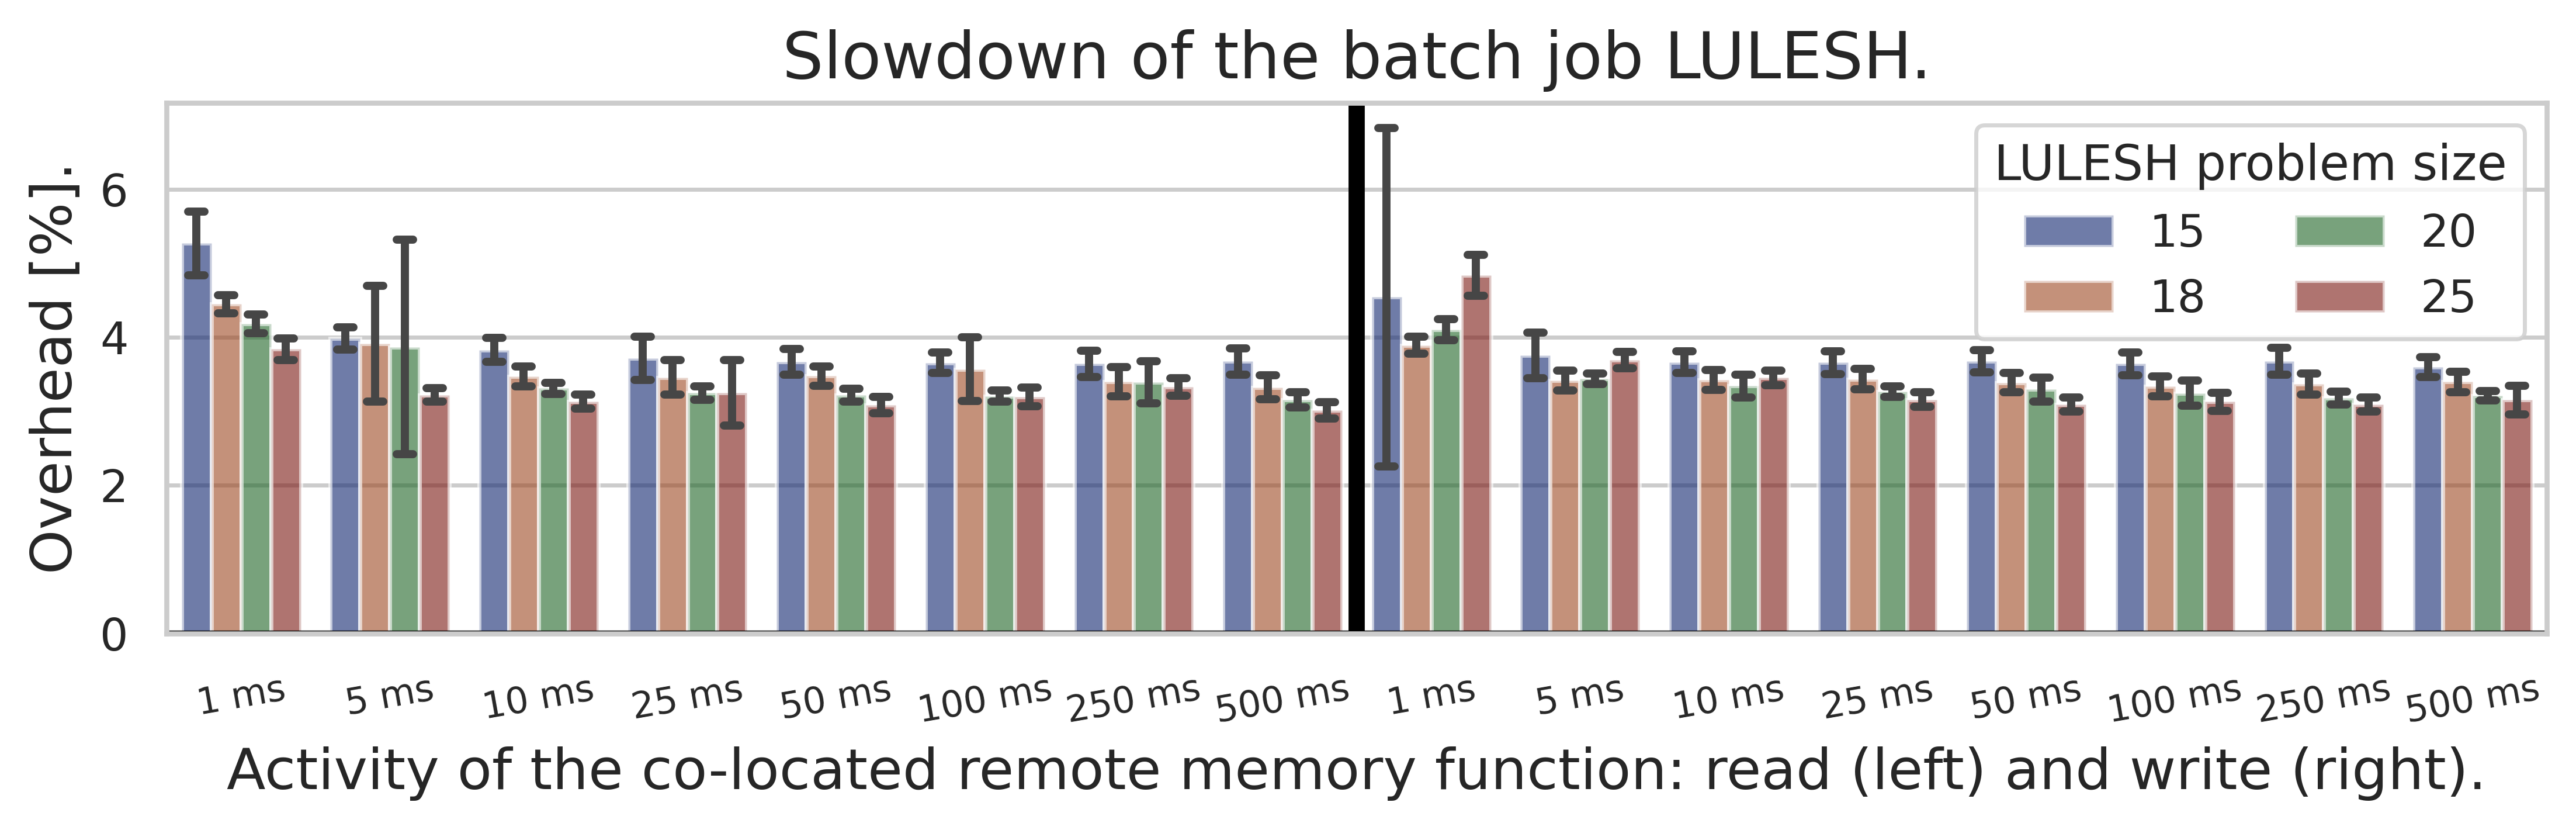

In [58]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_xlim([-0.5,15.5])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
plt.xticks(ticks,labels,fontsize=9, rotation=10)
#plt.xtickslabels(['a'])


plt.annotate("Baseline LULESH execution times:\n24.3, 48.4, 74.2, 191.8 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(1.5, -3.5), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.axvline(7.5, 0,5,color='black',linewidth=4)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "memory", "colocation_rma_lulesh_125.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)
